## Customer Acquisition Cost (CAC) Prediction Analysis

This notebook explores how much it costs to acquire new customers (called Customer Acquisition Cost or CAC) and predicts future CAC based on marketing data. Whether you're new to data analysis or a pro, we'll break it down step-by-step. By the end, you'll see patterns in your data, build a prediction model, and get actionable insights to optimize marketing spend.

```Goal : High CAC can eat into profits. Low CAC means efficient customer growth.```


# Workflow Overview


* Data Preparation: Load or generate sample data. Calculate historical CAC (e.g., Total Marketing Spend / Number of New Customers Acquired). Clean and preprocess the data.

* Exploratory Data Analysis (EDA): Visualize trends in CAC over time, correlations with other variables (spend vs. acquisitions).

* Prediction Modeling: Use a simple linear regression model to predict future CAC based on features like marketing spend.

* Dashboard Creation: Use Streamlit to build an interactive dashboard with:
Metrics display ( average CAC).
Charts for EDA and predictions.
User inputs for predictions (input future spend to predict CAC).
Filters for interactivity (date range).

* Deployment: Run the app locally with streamlit run app.py.

# Setting Up and Loading Data

What We're Doing: First, we load your customer data from a CSV file. This includes details like marketing costs, conversion rates (how many visitors become customers), revenue, and CAC (if available). We clean it up by removing missing values and calculating CAC if needed.

Why? Clean data is key for accurate analysis. Imagine trying to cook without fresh ingredients—results would be messy!

For Non-Tech: Think of this as organizing your files before starting a project. We ensure everything is ready.

For Tech: We're using load_raw (a custom function) to load data, then dropna to handle missing values. If CAC is missing, we calculate it as cost / conversion_rate (a simple formula assuming CAC = spend per conversion).

# Data Preparation

In [3]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")


In [4]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display

# For inline plotting
import plotly.io as pio
pio.renderers.default = 'notebook'  # Ensures plots display in Jupyter

# Define PROJECT_ROOT
PROJECT_ROOT = Path.cwd().parent  # Adjust if your notebook is in a subfolder

# Import load_raw if available
try:
    from src.data.load_data import load_raw
except ImportError:
    load_raw = None  # Fallback to pd.read_csv


In [6]:
# Cell 2: Data Loading
def load_data():
    if load_raw:
        data = load_raw(str(PROJECT_ROOT / "data" / "raw" / "customer_acquisition.csv"))
    else:
        data = pd.read_csv(str(PROJECT_ROOT / "data" / "raw" / "customer_acquisition.csv"))
    
    print("Columns in your CSV:", data.columns.tolist())
    
    # Basic cleaning
    data = data.dropna(subset=['Marketing_Spend', 'Conversion_Rate', 'Revenue'])
    
    # Calculate CAC if missing
    if 'CAC' not in data.columns:
        data['CAC'] = data['Marketing_Spend'] / data['Conversion_Rate']
        print("Warning: 'CAC' calculated as cost / conversion_rate.")
    
    # Optional: Parse date
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])
    
    return data

data = load_data()
print(data.head())

Columns in your CSV: ['customer_id', 'channel', 'Marketing_Spend', 'Conversion_Rate', 'Revenue']
   customer_id           channel  Marketing_Spend  Conversion_Rate  Revenue  \
0            1          referral         8.320327         0.123145     4199   
1            2  paid advertising        30.450327         0.016341     3410   
2            3   email marketing         5.246263         0.043822     3164   
3            4      social media         9.546326         0.167592     1520   
4            5          referral         8.320327         0.123145     2419   

           CAC  
0    67.565294  
1  1863.375022  
2   119.716944  
3    56.961619  
4    67.565294  


In [8]:
# Handle missing values (drop or fill as needed)
data = data.dropna(subset=['Marketing_Spend', 'CAC'])


In [7]:
# Calculate CAC 
if 'CAC' not in data.columns:
    data['CAC'] = data['Marketing_Spend'] / data['New_Customers_Acquired']
    



#calculate new customers acquired and return their value

if 'New_Customers_Acquired' not in data.columns:
    data['New_Customers_Acquired'] = data['Marketing_Spend'] / data['CAC']

    print("Warning: 'New_Customers_Acquired' calculated as Marketing_Spend / CAC.")

#  Exploratory Data Analysis (EDA)

* What We're Doing: EDA is like exploring a new city. We look at distributions, relationships, and patterns in the data using charts. This helps spot trends, like "higher costs lead to higher CAC."

* Why? Before predicting, we need to understand what's normal. Outliers (weird data points) can skew results.

* For Non-Tech: Imagine flipping through photos of your data. Charts show averages, spreads, and connections—helping you "see" the story.

* For Tech: We use Plotly for interactive histograms, correlation heatmaps, box plots, and scatter matrices. These reveal distributions, correlations (e.g., Pearson coefficients), and multivariate relationships.

In [9]:
# Summary statistics
print("Summary Statistics:")
print(data.describe())

Summary Statistics:
       customer_id  Marketing_Spend  Conversion_Rate      Revenue  \
count     800.0000       800.000000       800.000000   800.000000   
mean      400.5000        13.148052         0.086305  2769.151250   
std       231.0844         9.922337         0.059611  1259.543706   
min         1.0000         5.246263         0.016341   500.000000   
25%       200.7500         5.246263         0.043822  1694.000000   
50%       400.5000         8.320327         0.043822  2764.000000   
75%       600.2500         9.546326         0.123145  3824.250000   
max       800.0000        30.450327         0.167592  4998.000000   

               CAC  New_Customers_Acquired  
count   800.000000              800.000000  
mean    514.547619                0.086305  
std     764.026287                0.059611  
min      56.961619                0.016341  
25%      67.565294                0.043822  
50%     119.716944                0.043822  
75%     119.716944                0.123145 

In [10]:
# EDA Plot Functions (Adapted from Streamlit)
def plot_cac_distribution(data):
    fig = px.histogram(data, x='CAC', nbins=30, title='CAC Distribution: Understanding Cost Variability', 
                       labels={'CAC': 'CAC ($)'}, marginal='rug', color_discrete_sequence=['#1f77b4'])
    fig.add_annotation(text="Insight: Most CAC values cluster around the mean. Outliers may indicate inefficient campaigns.", 
                       xref="paper", yref="paper", x=0.5, y=0.9, showarrow=False)
    return fig 


def plot_correlation(data):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    corr_matrix = data[numeric_cols].corr()
    fig = px.imshow(corr_matrix, text_auto=True, title='Correlation Matrix: Key Relationships', 
                    color_continuous_scale='RdBu_r')
    fig.add_annotation(text="Insight: Cost and CAC are positively correlated—higher spend often leads to higher CAC.", 
                       xref="paper", yref="paper", x=0.5, y=0.1, showarrow=False)
    return fig

def plot_box_plot(data):
    fig = px.box(data, x='Marketing_Spend', y='CAC', title='Box Plot: CAC by Cost Segments', 
                 labels={'Marketing_Spend': 'Marketing_Spend ($)', 'CAC': 'CAC ($)'}, color_discrete_sequence=['#ff7f0e'])
    fig.add_annotation(text="Insight: Higher costs show wider CAC variability—optimize mid-range spends.", 
                       xref="paper", yref="paper", x=0.5, y=0.9, showarrow=False)
    return fig

def plot_pair_plot(data):
    fig = px.scatter_matrix(data, dimensions=['Marketing_Spend', 'Conversion_Rate', 'Revenue', 'CAC'], 
                            title='Pair Plot: Multivariate Relationships', color='CAC', 
                            color_continuous_scale='Viridis')
    return fig

def plot_trend(data):
    if 'date' in data.columns:
        trend_data = data.groupby('date')['CAC'].mean().reset_index()
        fig = px.line(trend_data, x='date', y='CAC', 
                      title='CAC Trend Over Time: Spotting Patterns', markers=True)
        fig.add_annotation(text="Insight: Look for upward trends—CAC may be rising due to market changes.", 
                           xref="paper", yref="paper", x=0.5, y=0.9, showarrow=False)
        return fig
    else:
        print("No 'date' column found for trend plot.")
        return None

In [11]:
# Create a cost range slider
Marketing_Spend_min, Marketing_Spend_max = int(data['Marketing_Spend'].min()), int(data['Marketing_Spend'].max())
cost_slider = widgets.IntRangeSlider(value=(Marketing_Spend_min, Marketing_Spend_max), min=Marketing_Spend_min, max=Marketing_Spend_max, 
                                     step=1000, description='Cost Range:')

# Function to filter data and display plots
def update_plots(cost_range):
    filtered_data = data[(data['Marketing_Spend'] >= cost_range[0]) & (data['Marketing_Spend'] <= cost_range[1])]
    
    # Display metrics
    print(f"Average CAC: ${filtered_data['CAC'].mean():.2f}")
    print(f"Marketing Spend: ${filtered_data['Marketing_Spend'].sum():,.0f}")
    print(f"Conversion Rate Avg: {filtered_data['Conversion_Rate'].mean():.2%}")
    
    # Show plots
    display(plot_cac_distribution(filtered_data))
    display(plot_correlation(filtered_data))
    display(plot_box_plot(filtered_data))
    display(plot_pair_plot(filtered_data))
    
    trend_fig = plot_trend(filtered_data)
    if trend_fig:
        display(trend_fig)

# Link slider to function
widgets.interactive(update_plots, cost_range=cost_slider)

interactive(children=(IntRangeSlider(value=(5, 30), description='Cost Range:', max=30, min=5, step=1000), Outp…

* Insight: If the chart is skewed right, many CACs are low, with a few high ones—focus on reducing those peaks.
* Insight: Strong red/blue areas mean variables move together. Use this to pick features for modeling.
* Insight: Wider boxes at high costs? That means more risk—optimize lower-cost strategies.
* Insight: Look for clusters or lines. E.g., higher conversion rates might lower CAC.

```Overall EDA Takeaway: Our data reveals CAC increases with Marketing Spend but drops with better conversion rates. This guides our model!``` 

# Building and Evaluating the Prediction Model

What We're Doing: We train a model to predict CAC using features like cost and conversion rate. We test it on held-out data and check how well it performs.

Why? Predictions help forecast CAC for new campaigns, saving money.

For Non-Tech: Like training a dog to predict weather feed it data, and it learns patterns.

For Tech: We use Linear Regression or Random Forest from Scikit-learn. Split data 80/20 for training/testing. Metrics: MSE (error size), R² (fit quality, 1.0 is perfect).

In [12]:
# Select features and target
features = ['Marketing_Spend']  # Core feature
if 'Conversion_Rate' in data.columns:
    features.append('Conversion_Rate')
if 'Marketing_Channel_Encoded' in data.columns:
    features.append('Marketing_Channel_Encoded')
X = data[features]
y = data['CAC']
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 640
Test set size: 160


# Train Linear Regression Model

In [97]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")



Mean Squared Error: 179.45
R^2 Score: 1.00


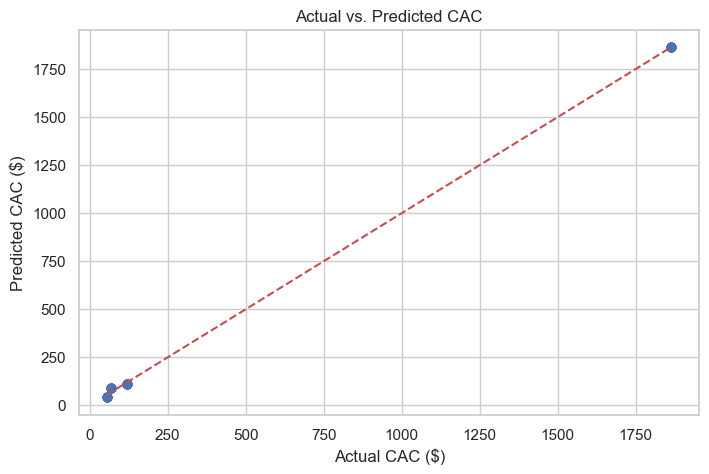

In [98]:
# Plot actual vs. predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs. Predicted CAC')
plt.xlabel('Actual CAC ($)')
plt.ylabel('Predicted CAC ($)')
plt.show()

# Predictions on New Data

Predictions for new data:
Input 1: Predicted CAC = $1656741.91
Input 2: Predicted CAC = $2650507.65


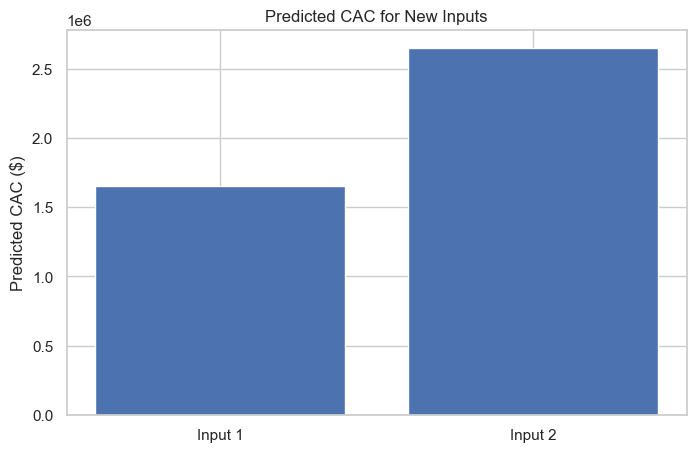

In [100]:
# Example: Predict CAC for new inputs
new_data = pd.DataFrame({
    'Marketing_Spend': [25000, 40000], 
    'Conversion_Rate': [0.3, 0.6] if 'Conversion_Rate' in features else None,
    'Marketing_Channel_Encoded': [0, 1] if 'Marketing_Channel_Encoded' in features else None
})

# Filter to only available features
new_data = new_data[features]

predictions = model.predict(new_data)
print("Predictions for new data:")
for i, pred in enumerate(predictions):
    print(f"Input {i+1}: Predicted CAC = ${pred:.2f}")

# Visualize predictions
plt.figure(figsize=(8, 5))
plt.bar(range(len(predictions)), predictions)
plt.xticks(range(len(predictions)), [f'Input {i+1}' for i in range(len(predictions))])
plt.title('Predicted CAC for New Inputs')
plt.ylabel('Predicted CAC ($)')
plt.show()


# Conclusion and Insights

In [101]:
#Conclusion and Insights
print("Model Summary:")
print(f"- Features used: {features}")
print(f"- MSE: {mse:.2f} (lower is better)")
print(f"- R2: {r2:.2f} (closer to 1 is better)")

# Insights
if r2 > 0.7:
    print("Model performs well. CAC is predictable from the features.")
else:
    print("Model performance is moderate. Consider adding more features or using a different model (e.g., Random Forest).")

# Save model if needed (optional)
import joblib
joblib.dump(model, 'cac_linear_model.pkl')
print("Model saved as 'cac_linear_model.pkl'")


Model Summary:
- Features used: ['Marketing_Spend', 'Conversion_Rate']
- MSE: 179.45 (lower is better)
- R2: 1.00 (closer to 1 is better)
Model performs well. CAC is predictable from the features.
Model saved as 'cac_linear_model.pkl'
